In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.cbook import get_sample_data
import tkinter as tk
from tkinter import filedialog
import datetime as dt
import plotly.express as px
from dash import Dash, dcc, html
from base64 import b64encode


In [2]:
font = {'size': 40}

matplotlib.rc('font', **font)
pd.set_option('display.max_rows', 500, 'display.max_columns', 20, 'display.width', 1000)
plt.rcParams.update({"axes.grid": True})

Define basic parameters

In [3]:
SAVE_PDF = 1
SAVE_HTML = 1
PLOT = 0
EXPORT = 0

n_cycles = 5
velocity_trigger = 7
step_from = 0
step_to = 15
step_size = 1.5
step_travel_time_minus = 0.1
step_travel_time_plus = 0.1

spec = 0.1
spec_sync_slow = 0.1
spec_sync_fast = 0.1

Configurate test parameters

In [4]:
id = 'Initial-Test_'
weight = '0N'
cycles = '0'
Set_No = 0
date = str(dt.date.today())
temperature = 'RT'
author = 'LOJI'

if Set_No == 0:
    Liftertyp = 'PP_B2_15mm'
    lbl1 = 'ACH4-0001'
    lbl2 = 'ACH4-0002'
    lbl3 = 'ACH4-0003'

if Set_No == 1:
    Liftertyp = 'PP_B2_30mm'
    lbl1 = 'ACM4-0001'
    lbl2 = 'ACM4-0002'
    lbl3 = 'ACM4-0003'

title_accuracy_measurement = 'Position accuracy measurement - motion profile - ' + Liftertyp 
title_accuracy = 'Position accuracy - ' + Liftertyp + ' / ' + temperature + ' / ' + weight + ' load ' + ' / after ' + cycles + ' cycles'
title_sync_measurement = 'Position synchronicity measurement - motion profile - ' + Liftertyp
title_sync = 'Position synchronicity - ' + Liftertyp + ' / ' + temperature + ' / ' + weight + ' load' + ' / after ' + cycles + ' cycles'

Import datafile and preprocess dataframe -> import timeline and monitor the sampling frequency of the sensor

3281957_Accuracy-Sync_PP-Reduced_SET1_0-cycles_RT_VAC_0N.csv
The sample frequency of the sensor is 1499 Hz
220 / 220 trigger detected


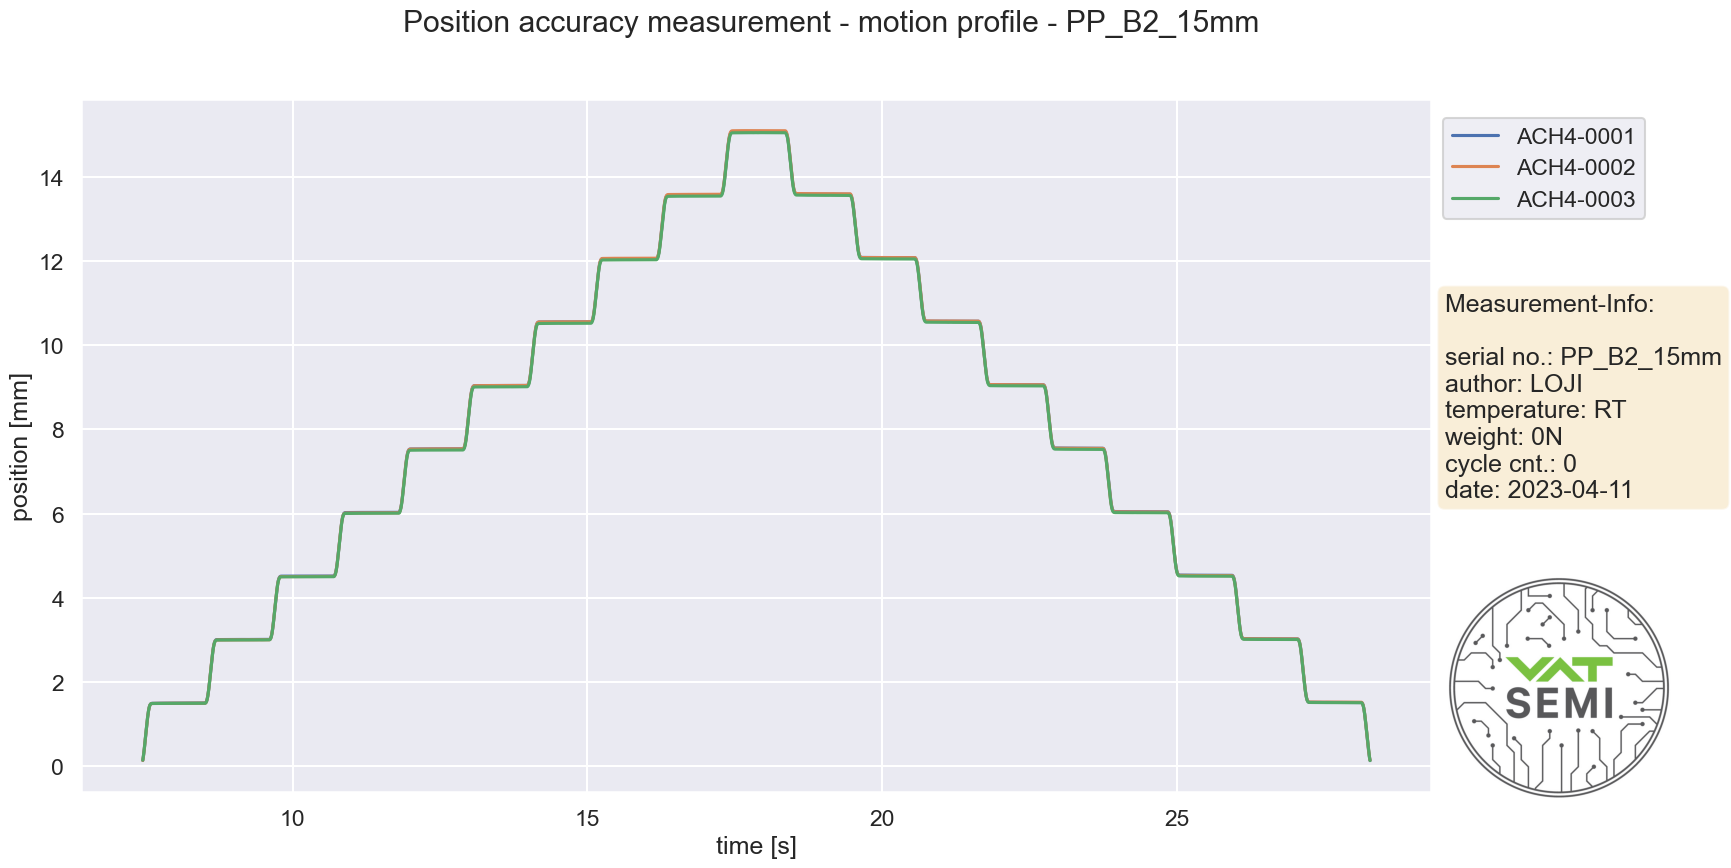

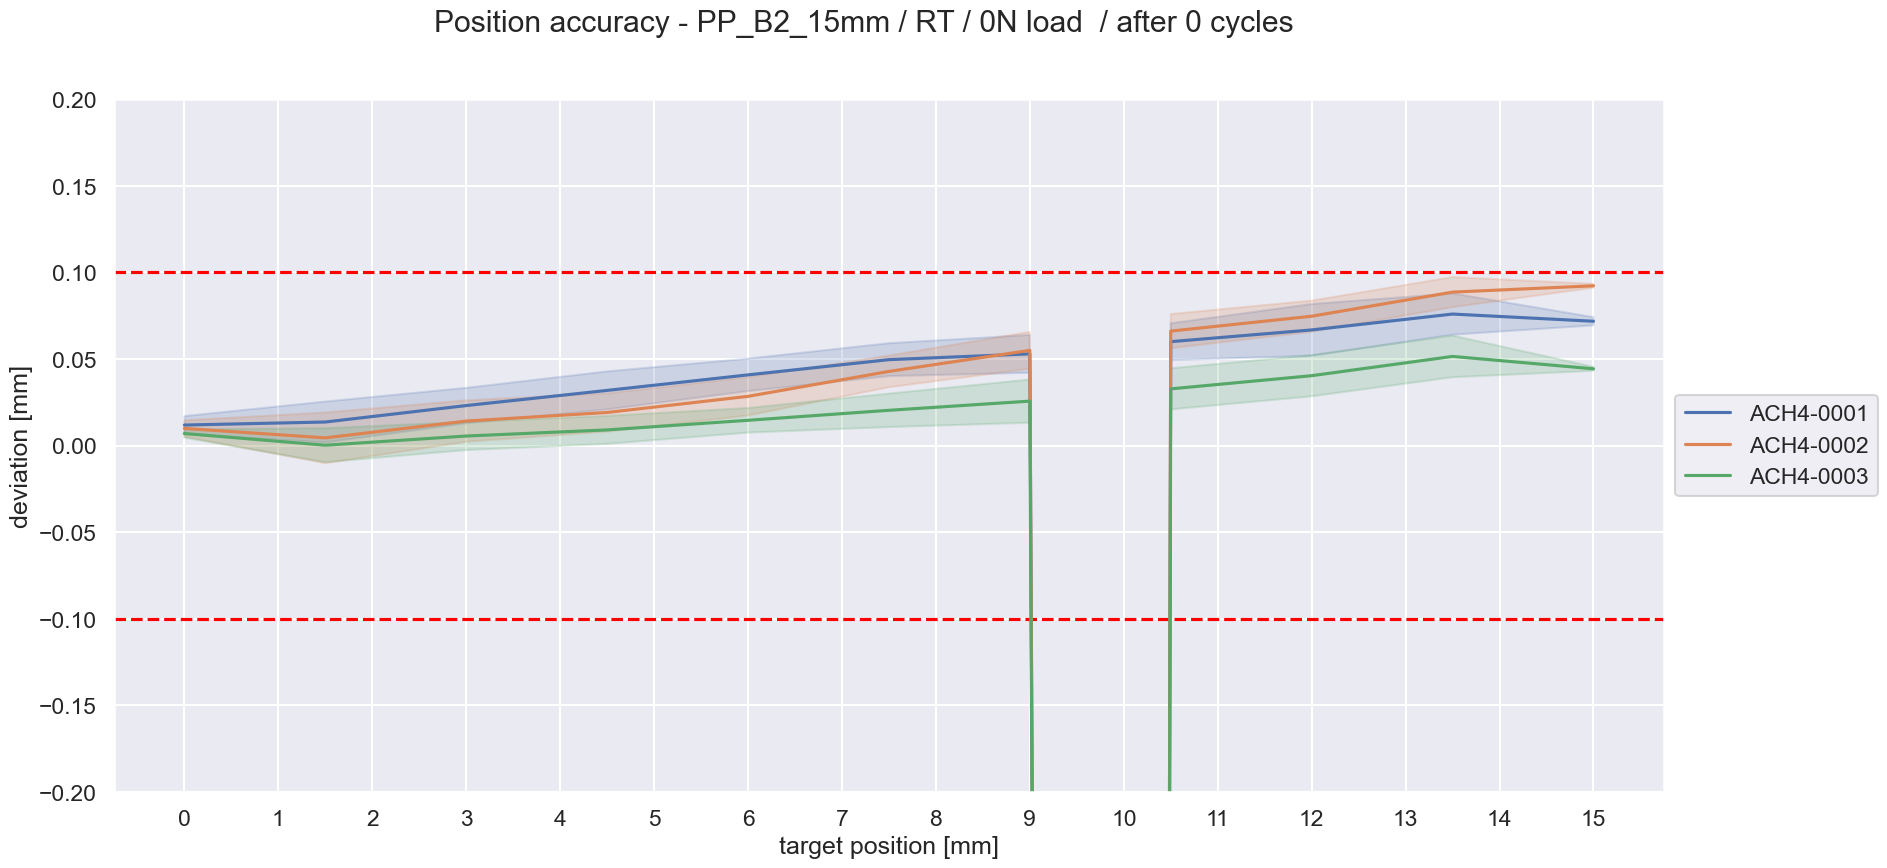

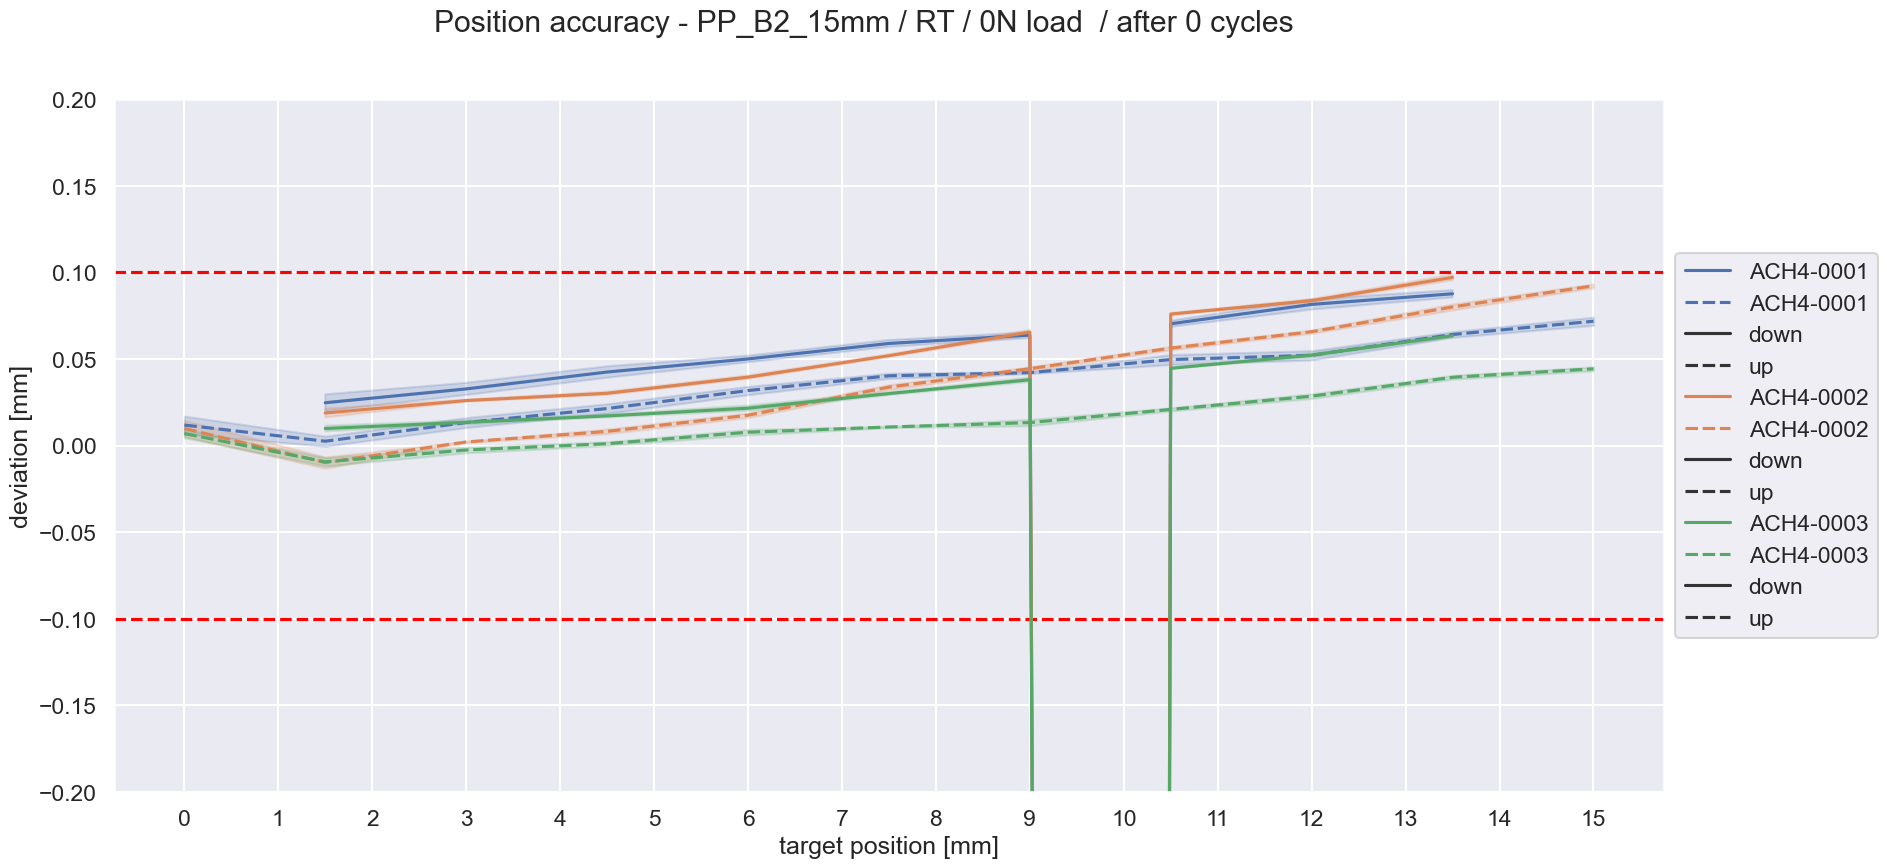

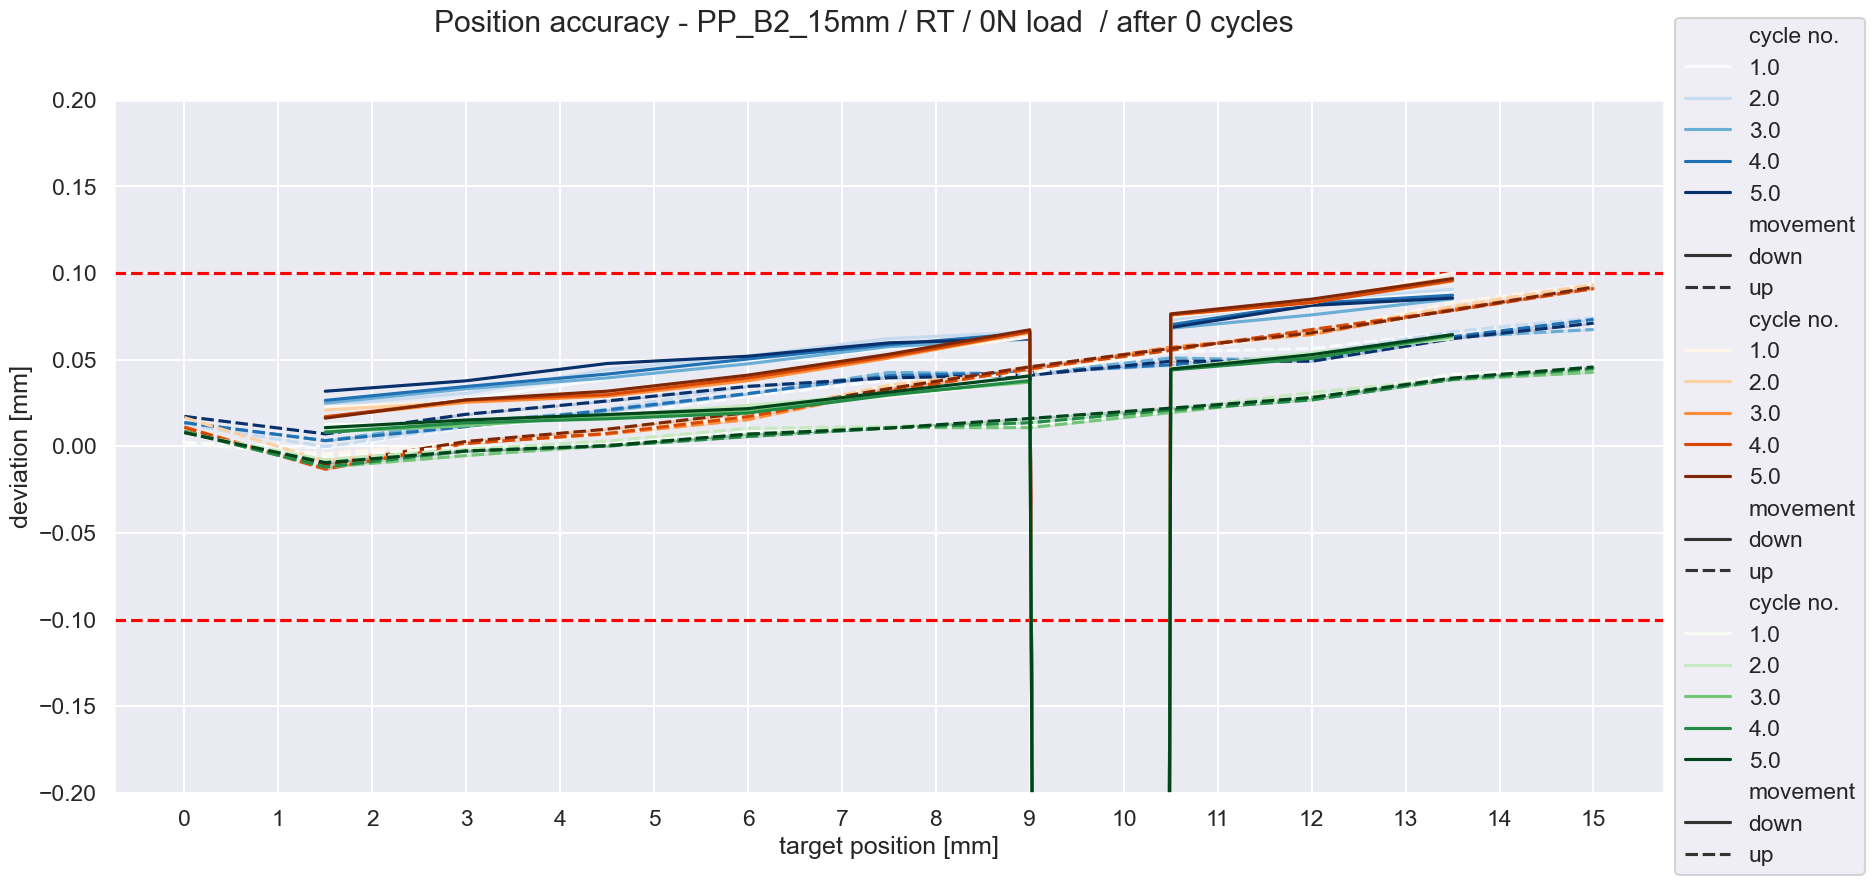

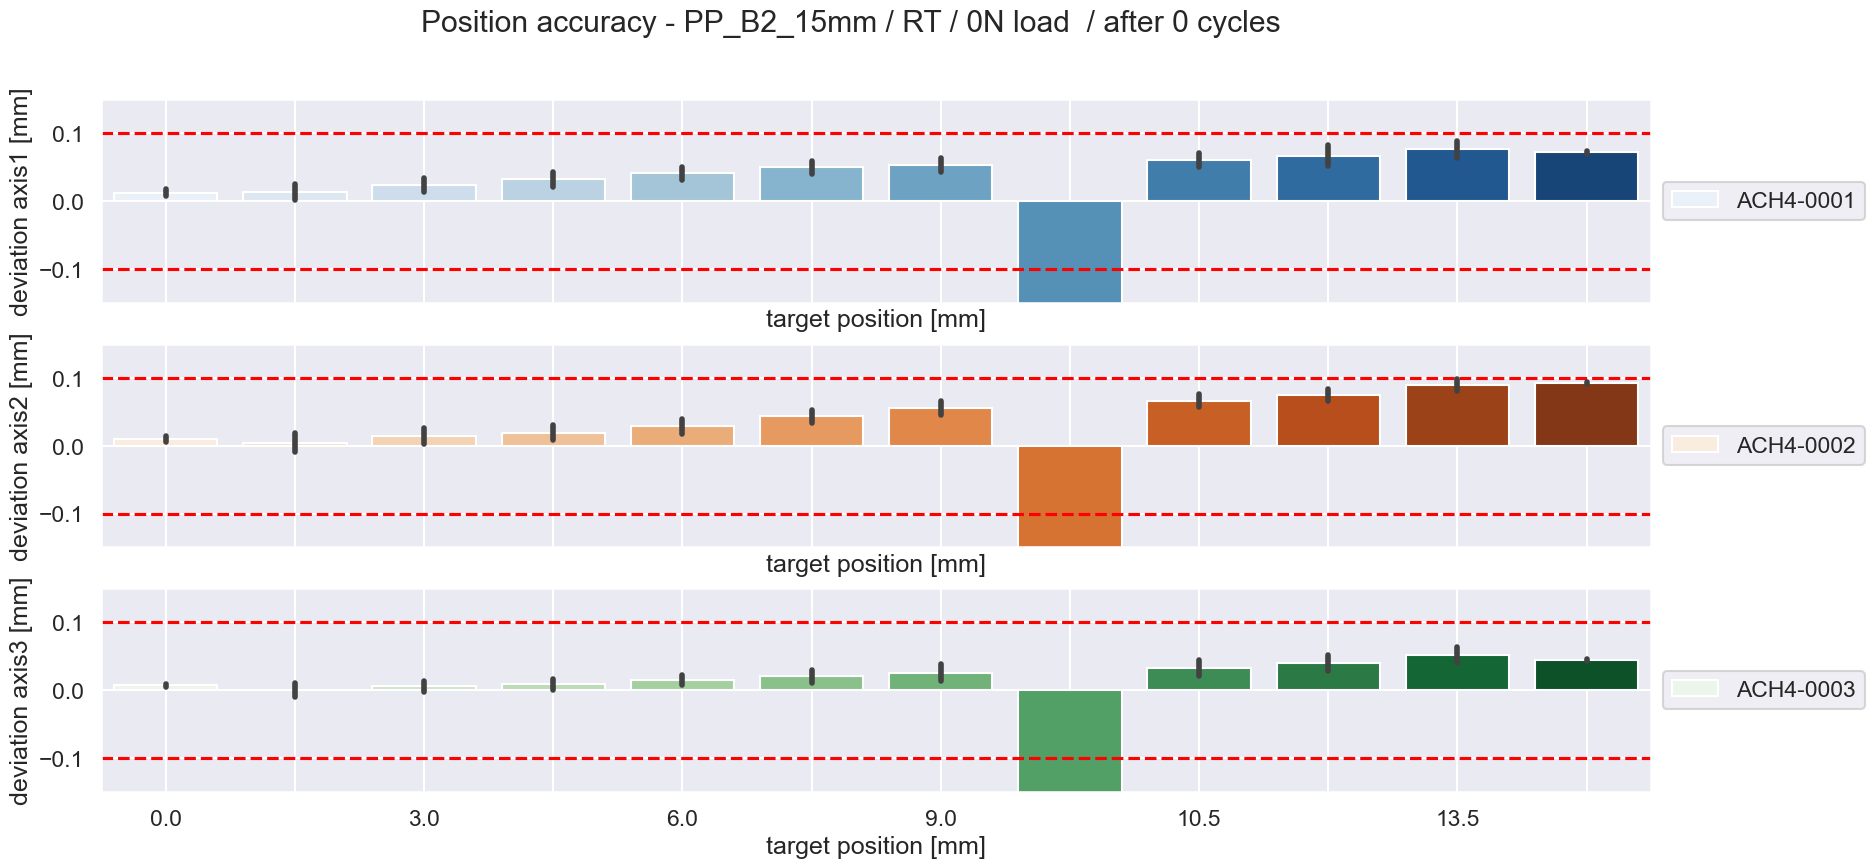

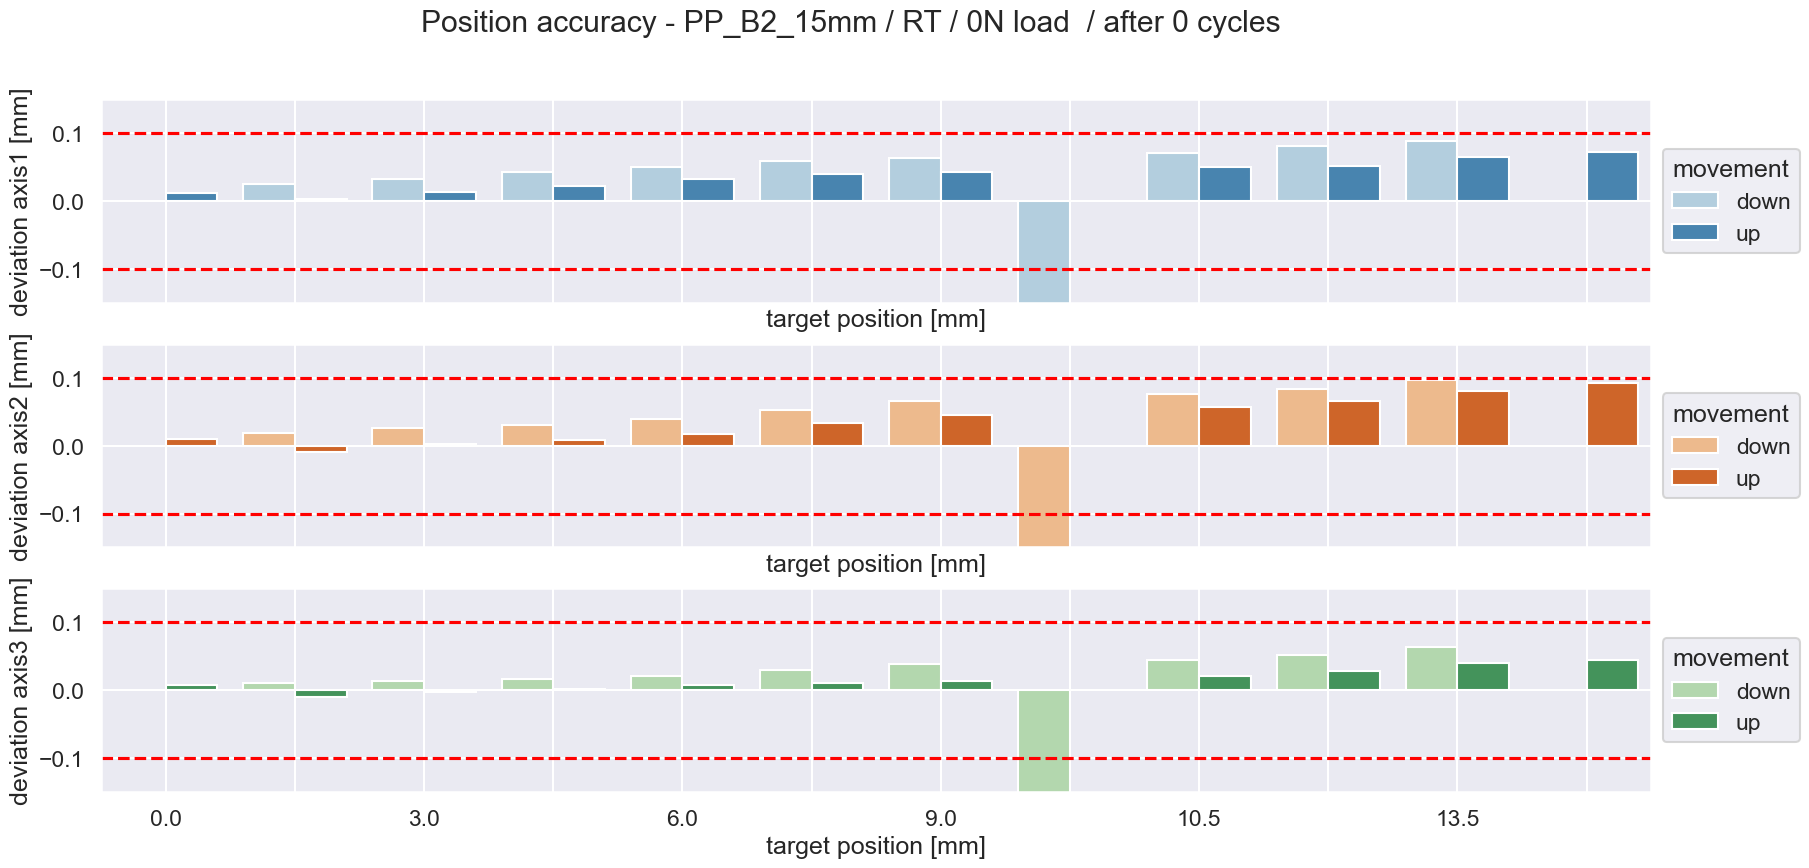

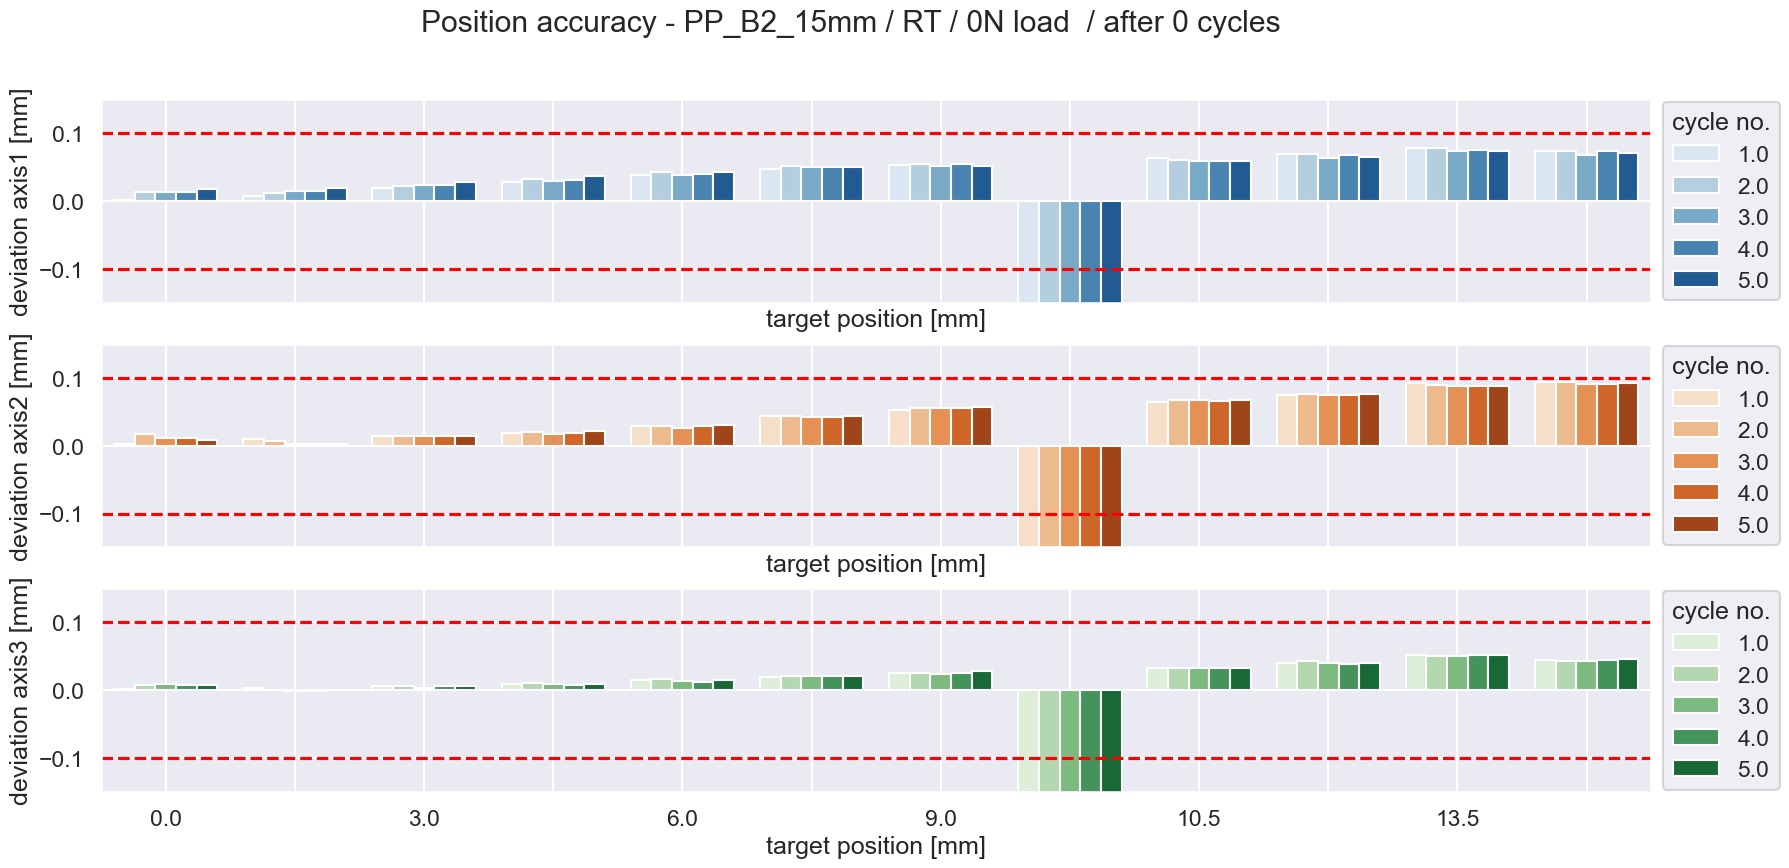

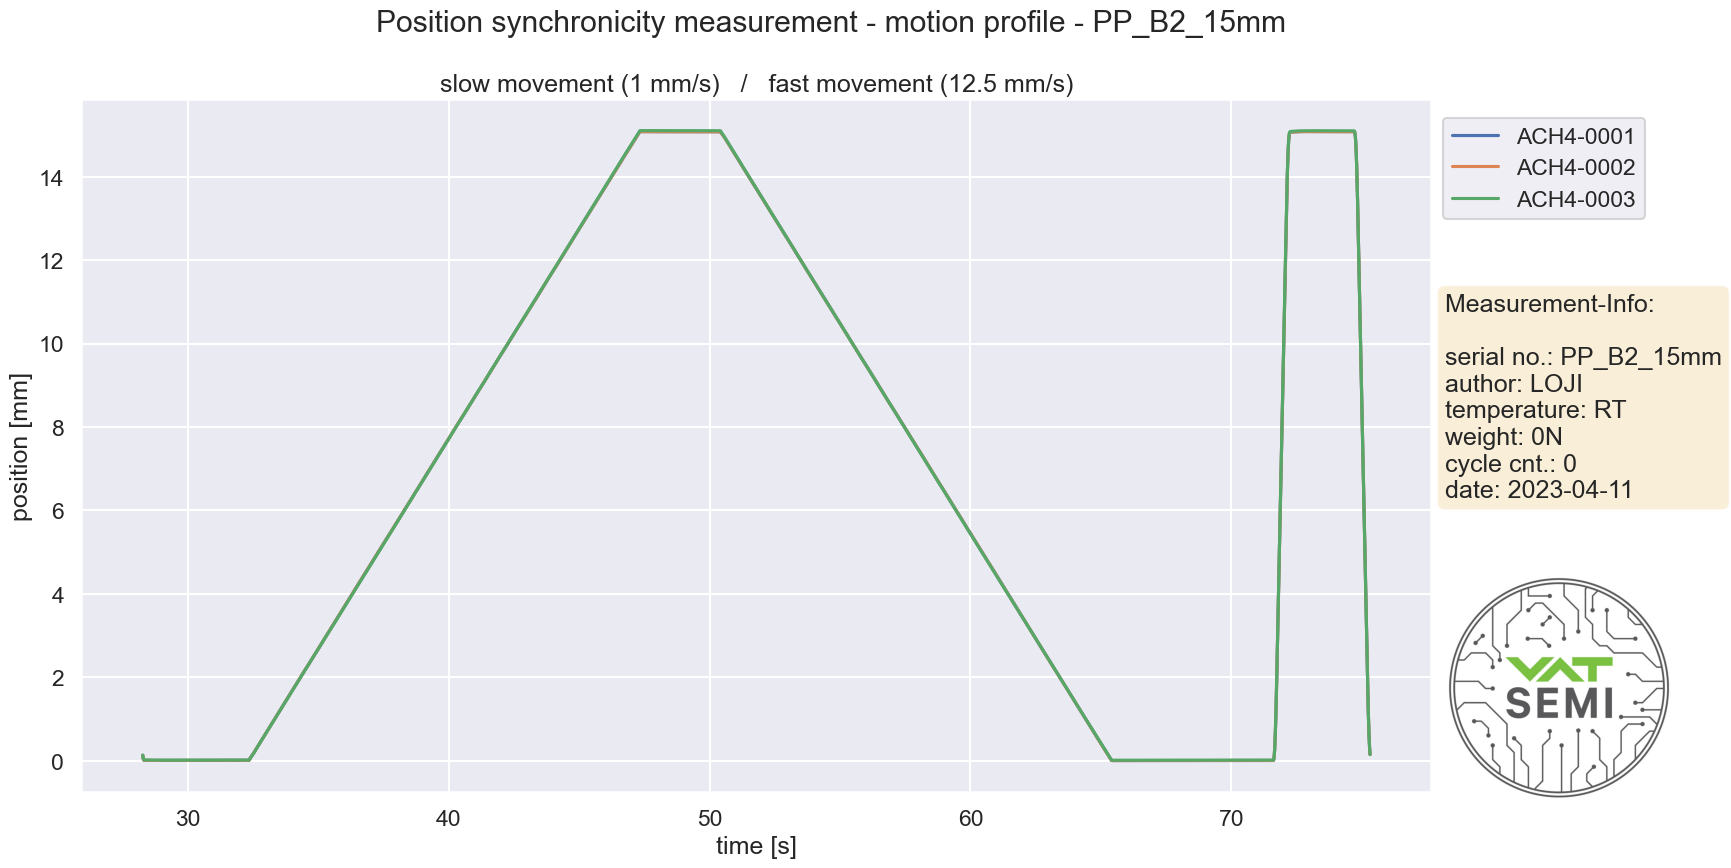

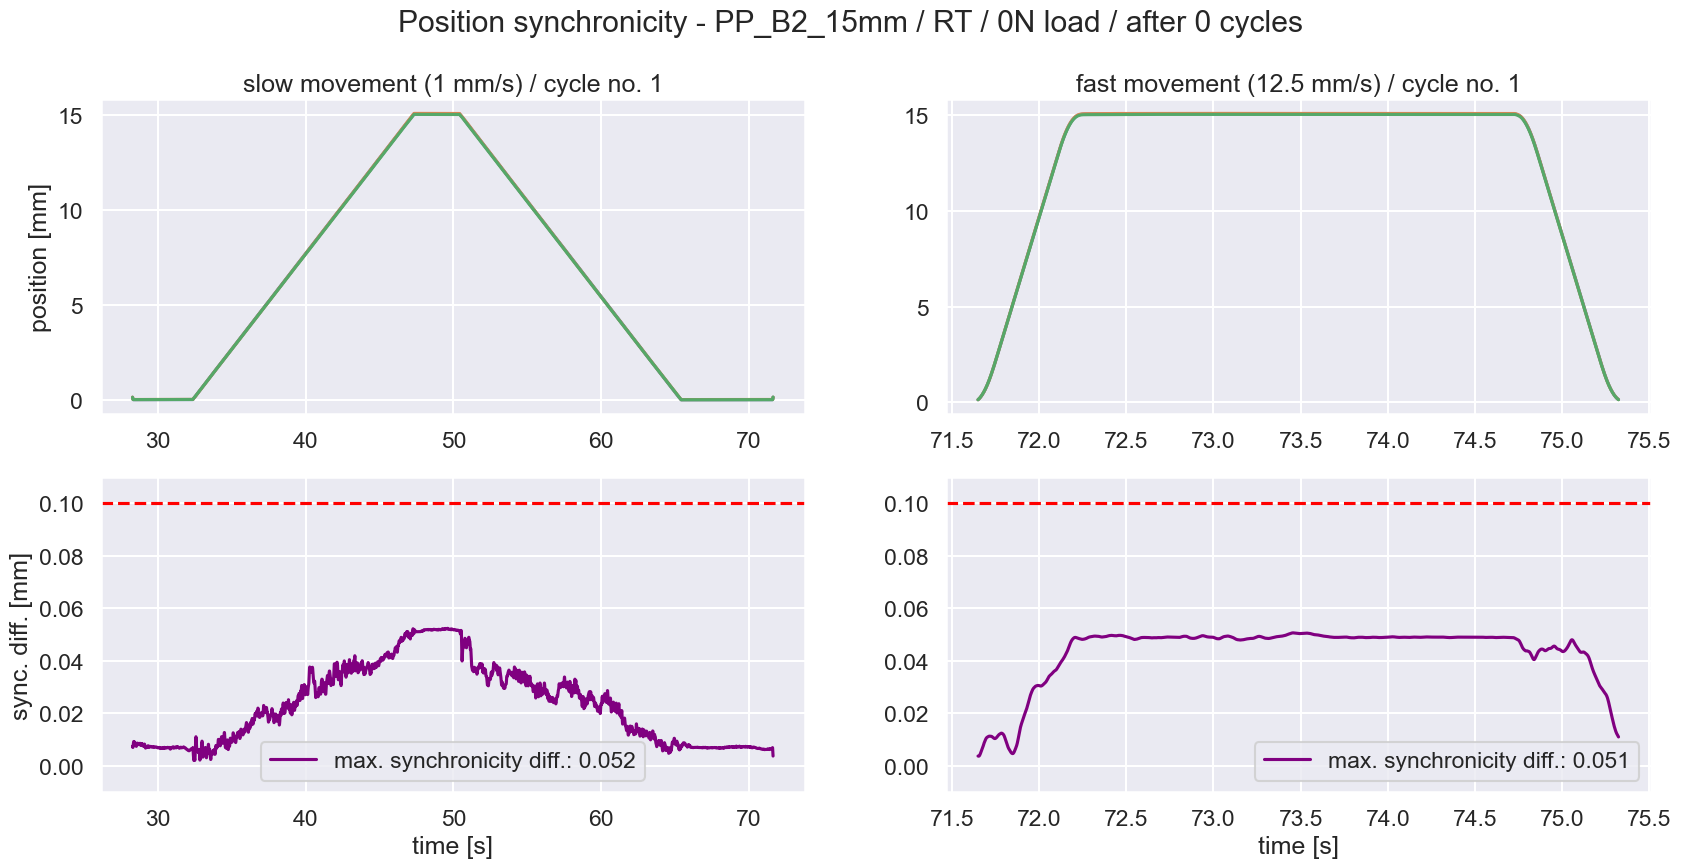

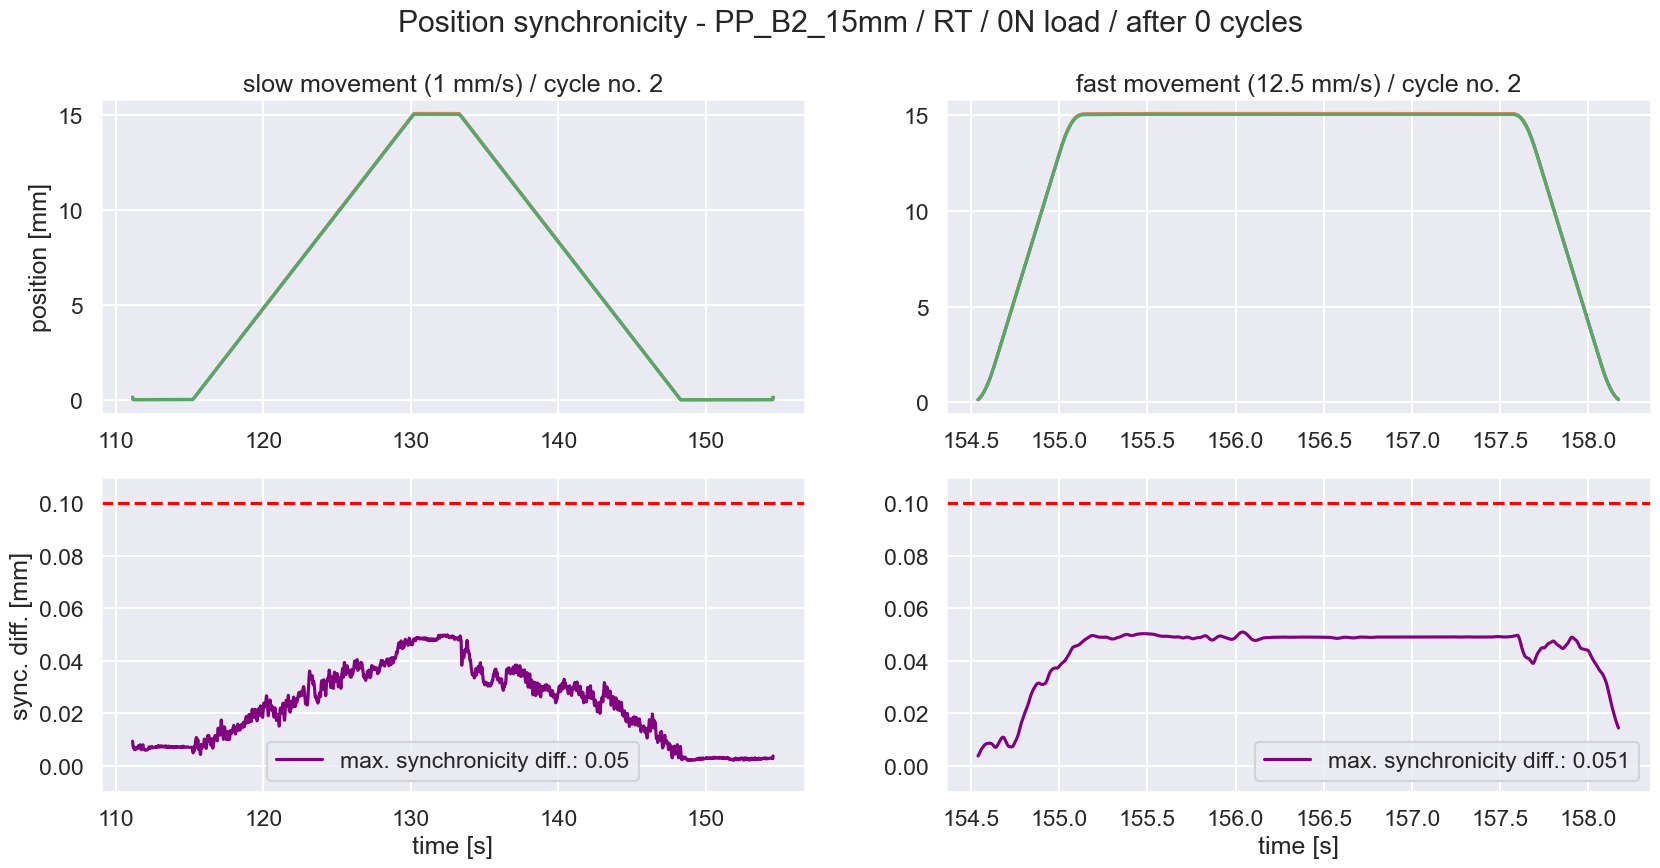

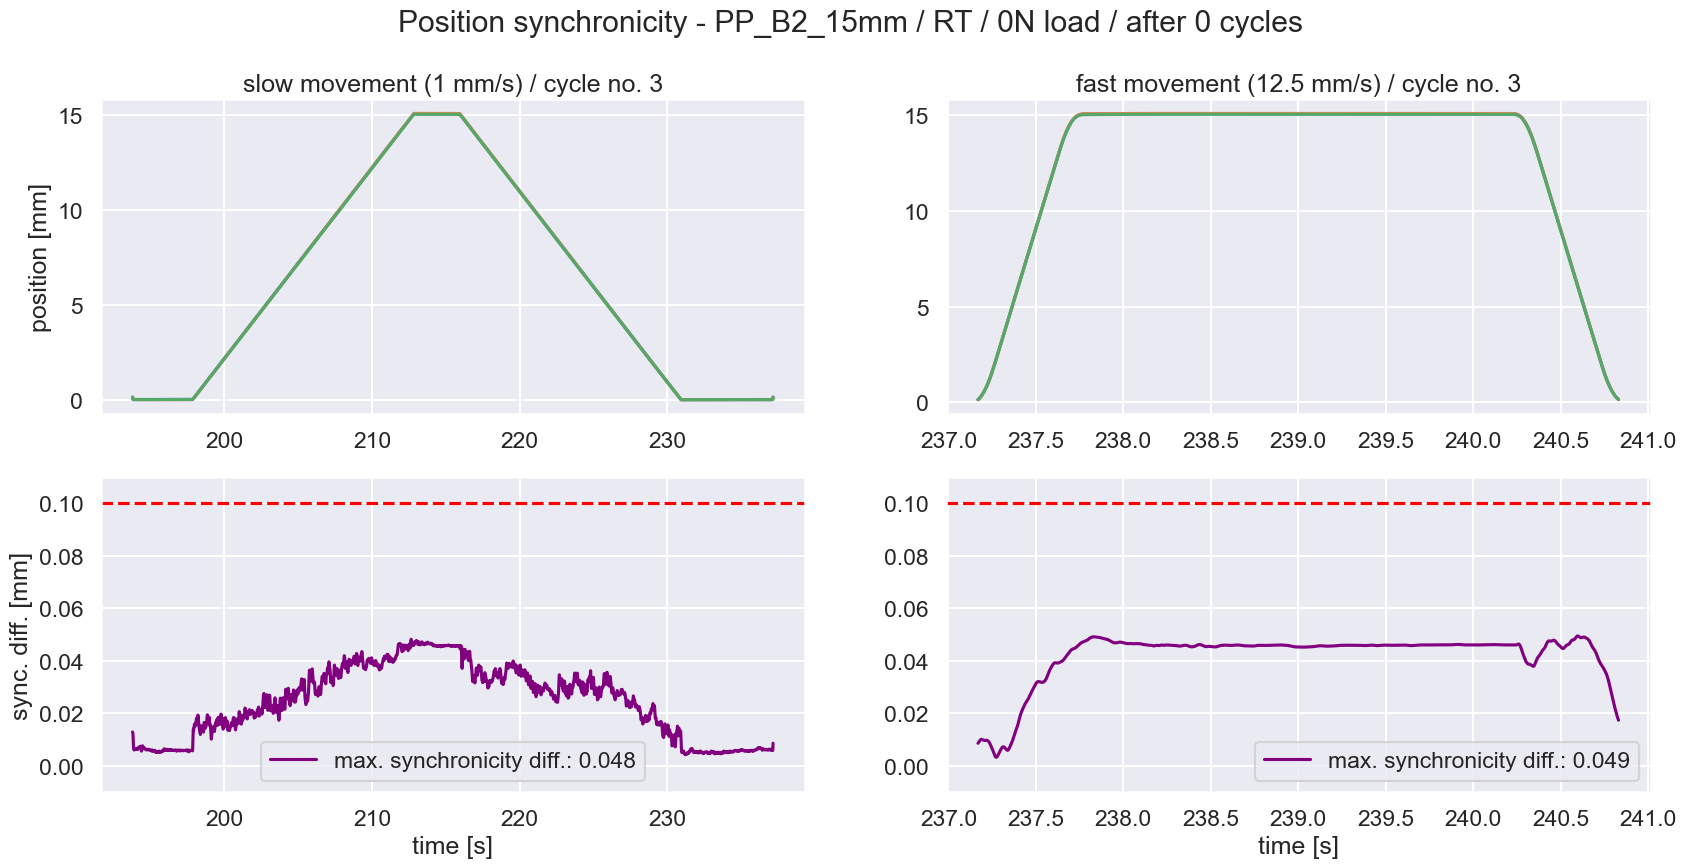

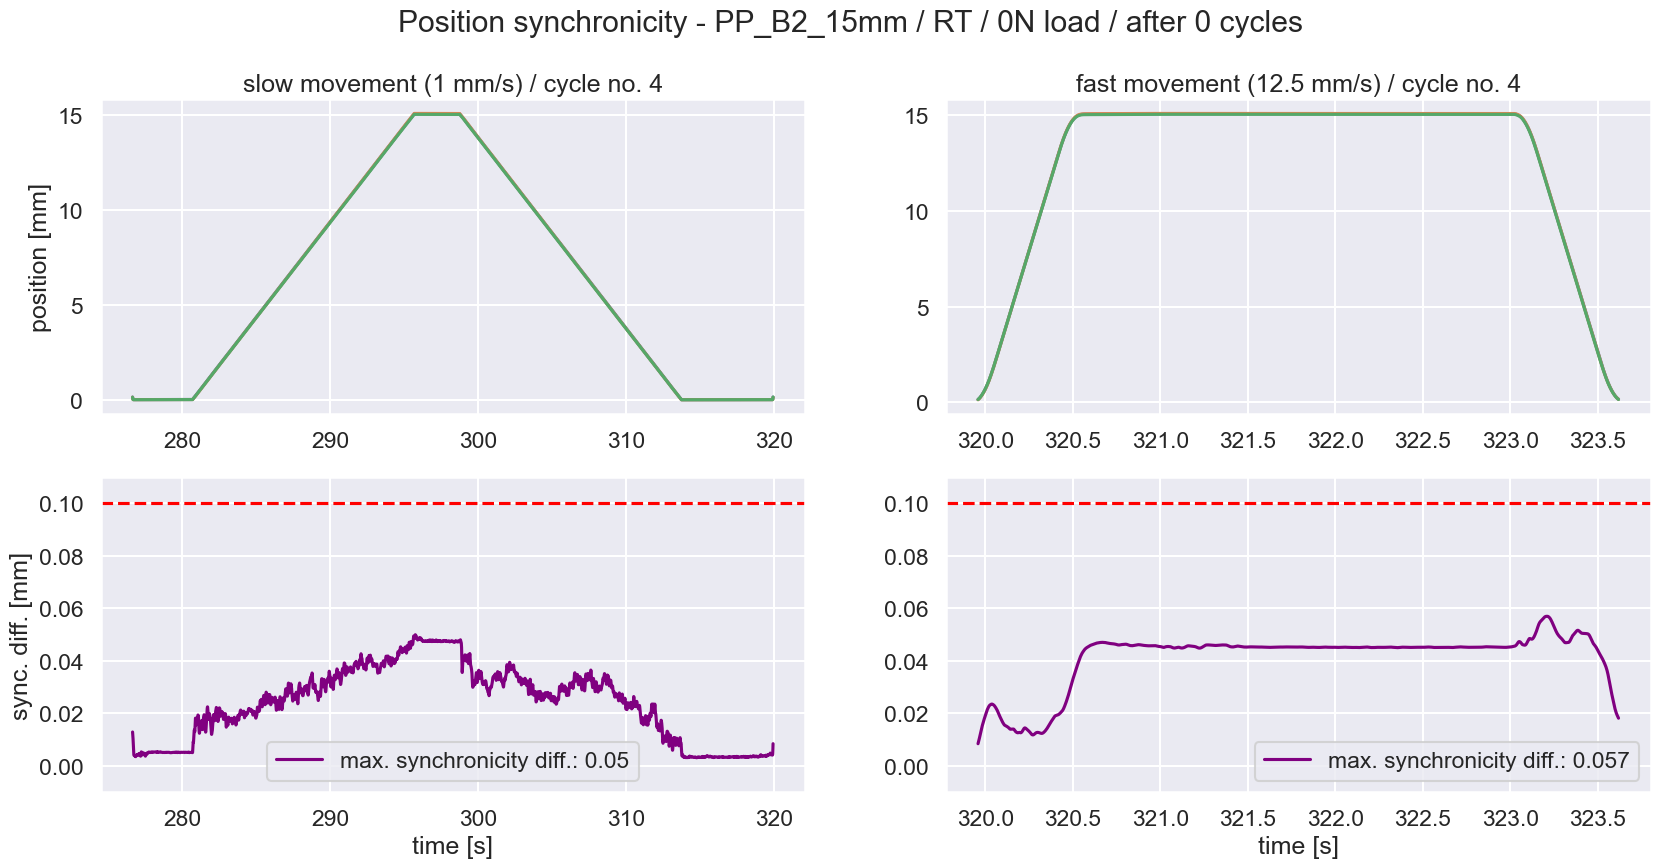

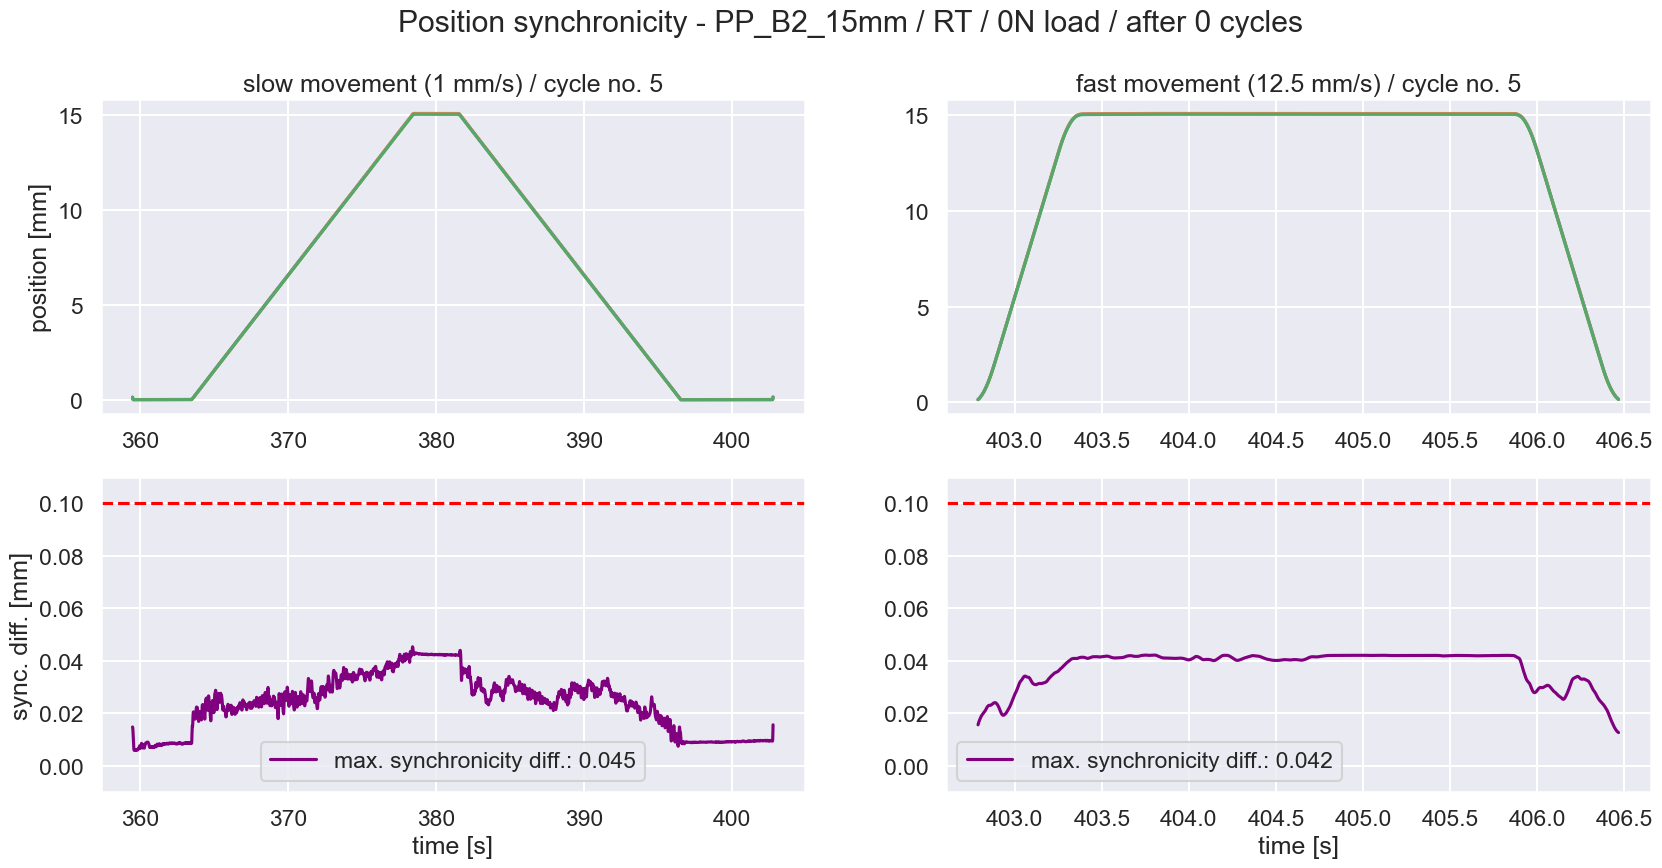

In [6]:
def main():
    root = tk.Tk()
    root.withdraw()
    files_path = filedialog.askopenfilenames(title='Select input files')

    if SAVE_PDF == 1 or SAVE_HTML == 1:
        root = tk.Tk()
        root.withdraw()
        FOLDEROUT = filedialog.askdirectory(title='Select output folder')
        if SAVE_PDF == 1:
            pdf = matplotlib.backends.backend_pdf.PdfPages(FOLDEROUT + '/' + id + Liftertyp + '_' + cycles 
                                                           + '-cycles' + '_' + temperature + '_' + weight + '.pdf')
        if SAVE_HTML == 1:
            filename_html = FOLDEROUT + '/' + id + Liftertyp + ' _' + cycles + '-cycles' + '_' + temperature + '_' + weight + '.html'
    
    counter = 0
    for files_path in files_path:
        file_name = files_path.split('/')
        file = file_name[-1]
        print(file)
        csv_import = pd.read_csv(files_path, parse_dates=True, infer_datetime_format=True, skiprows=11, header=None,
                                    index_col=0, names=['position axis1 [mm]', 'position axis2 [mm]', 'position axis3 [mm]', 'time [s]'])
        df_import = pd.DataFrame(csv_import)

        for column in df_import:
            df_import[column] = pd.to_numeric(df_import[column], errors='coerce')

        if counter == 0:
            DF = df_import
        else:
            DF = DF.merge(df_import, how='outer')
        counter = counter + 1

    del df_import
    del csv_import

    DF['time [s]'] = pd.to_datetime(DF.index)
    DF['time [s]'] = (DF['time [s]'] - DF['time [s]'][0]).dt.total_seconds()
    time_diff = DF['time [s]'].diff()
    sampling_frequency = round(1/float(DF['time [s]'][1]))
    print('The sample frequency of the sensor is' + ' ' + str(sampling_frequency) + ' Hz')
    
    smooth_pts = round(sampling_frequency / 50)
    DF['position axis1 [mm]'] = DF['position axis1 [mm]'].rolling(window=smooth_pts).mean()
    DF['position axis2 [mm]'] = DF['position axis2 [mm]'].rolling(window=smooth_pts).mean()
    DF['position axis3 [mm]'] = DF['position axis3 [mm]'].rolling(window=smooth_pts).mean()

    DF = DF.iloc[smooth_pts-1:,:]
    DF.reset_index(drop=True, inplace=True)

    DF['velocity axis1 [mm/s]'] = DF['position axis1 [mm]'].diff()/DF['time [s]'].diff()
    DF['velocity axis2 [mm/s]'] = DF['position axis2 [mm]'].diff()/DF['time [s]'].diff()
    DF['velocity axis3 [mm/s]'] = DF['position axis3 [mm]'].diff()/DF['time [s]'].diff()

    DF['velocity_trigger'] = False
    DF.loc[DF['velocity axis1 [mm/s]'] > velocity_trigger, 'velocity_trigger'] = True
    DF.loc[DF['velocity axis1 [mm/s]'] < -velocity_trigger, 'velocity_trigger'] = True

    DF['step_trigger'] = False
    DF.loc[DF['velocity_trigger'].diff() == 1, 'step_trigger'] = True
    step_trigger_idx = list(DF.loc[DF['step_trigger'] == True].index)

    step_range = len(step_trigger_idx)
    for i in range(step_range):
        if i % 2 == 0:
            step_trigger_idx[i] = step_trigger_idx[i] - round(step_travel_time_minus * sampling_frequency)
        else:
            step_trigger_idx[i] = step_trigger_idx[i] + round(step_travel_time_plus * sampling_frequency)

    step_trigger_cnt = int(((step_to - step_from) / step_size * 4) + 4)
    if step_range % n_cycles == 0:
        print(str(step_range) + ' / ' + str(step_trigger_cnt * n_cycles) + ' trigger detected')
    else: 
        print('Invalid number of triggers detected! --> ' + str(step_range))

    offset_idx = step_trigger_idx[0]
    offset_axis1 = DF.loc[(offset_idx - sampling_frequency) : offset_idx, 'position axis1 [mm]'].mean(axis=0)
    DF['position axis1 [mm]'] = -(DF['position axis1 [mm]'] - offset_axis1)
    offset_axis2 = DF.loc[(offset_idx - sampling_frequency) : offset_idx, 'position axis2 [mm]'].mean(axis=0)
    DF['position axis2 [mm]'] = -(DF['position axis2 [mm]'] - offset_axis2)
    offset_axis3 = DF.loc[(offset_idx - sampling_frequency) : offset_idx, 'position axis3 [mm]'].mean(axis=0)
    DF['position axis3 [mm]'] = -(DF['position axis3 [mm]'] - offset_axis3)

    DF['sync_diff'] = DF[['position axis1 [mm]', 'position axis2 [mm]', 'position axis3 [mm]']].max(axis=1) - \
        DF[['position axis1 [mm]', 'position axis2 [mm]', 'position axis3 [mm]']].min(axis=1)
    DF['sync_diff'] = DF['sync_diff'].rolling(window=smooth_pts * 2). mean()

    DF['sync_slow'] = False
    DF['sync_fast'] = False
    DF['accuracy'] = False
    for cycle_id in range(n_cycles, 0, -1):
        idx = DF.loc[DF['step_trigger'] == True][(cycle_id -1) * (step_trigger_cnt) : (cycle_id) * (step_trigger_cnt)].index
        idx_start = idx[0]
        idx_end = idx[-1]
        DF.loc[idx_start:idx_end, 'cycle no.'] = int(cycle_id)
        DF.loc[idx_start:idx_end, 't_cycle [s]'] = DF.loc[idx_start:idx_end, 'time [s]'] - DF.loc[idx_start, 'time [s]']

        idx_01 = DF.loc[DF['step_trigger'] == True][(cycle_id -1) * (step_trigger_cnt) : ((cycle_id) * (step_trigger_cnt) - 4)].index
        idx_start_01 = idx_01[0]
        idx_end_01 = idx_01[-1]
        DF.loc[idx_start_01:idx_end_01, 'accuracy'] = True
        
        step_index = len(idx_01)
        for step_id in range(step_index, -2, -2):
            if step_id == step_index:
                DF.loc[idx_end_01 : (idx_end_01 + sampling_frequency), 'stepsAxis1'] = DF.loc[idx_end_01 : idx_end_01 + sampling_frequency, \
                                                                                            'position axis1 [mm]'].mean(axis=0)
                DF.loc[idx_end_01 : (idx_end_01 + sampling_frequency), 'stepsAxis2'] = DF.loc[idx_end_01 : idx_end_01 + sampling_frequency, \
                                                                                            'position axis2 [mm]'].mean(axis=0)
                DF.loc[idx_end_01 : (idx_end_01 + sampling_frequency), 'stepsAxis3'] = DF.loc[idx_end_01 : idx_end_01 + sampling_frequency, \
                                                                                            'position axis3 [mm]'].mean(axis=0)
                DF.loc[idx_end_01 : (idx_end_01 + sampling_frequency), 'target position [mm]'] = (step_to - step_from) / step_size
                DF.loc[idx_end_01 : (idx_end_01 + sampling_frequency), 'movement'] = 'down'
            elif step_id == 0:
                DF.loc[(idx_start_01 - sampling_frequency) : idx_start_01, 'stepsAxis1'] = DF.loc[idx_start_01 - sampling_frequency : idx_start_01, \
                                                                                                'position axis1 [mm]'].mean(axis=0)
                DF.loc[(idx_start_01 - sampling_frequency) : idx_start_01, 'stepsAxis2'] = DF.loc[idx_start_01 - sampling_frequency : idx_start_01, \
                                                                                                 'position axis2 [mm]'].mean(axis=0)
                DF.loc[(idx_start_01 - sampling_frequency) : idx_start_01, 'stepsAxis3'] = DF.loc[idx_start_01 - sampling_frequency : idx_start_01, \
                                                                                                 'position axis3 [mm]'].mean(axis=0)
                DF.loc[(idx_start_01 - sampling_frequency) : idx_start_01, 'target position [mm]'] = 0
                DF.loc[(idx_start_01 - sampling_frequency) : idx_start_01, 'movement'] = 'up'
            else:
                DF.loc[idx[step_id-1]:idx[step_id], 'stepsAxis1'] = DF.loc[idx[step_id-1]:idx[step_id], 'position axis1 [mm]'].mean(axis=0)
                DF.loc[idx[step_id-1]:idx[step_id], 'stepsAxis2'] = DF.loc[idx[step_id-1]:idx[step_id], 'position axis2 [mm]'].mean(axis=0)
                DF.loc[idx[step_id-1]:idx[step_id], 'stepsAxis3'] = DF.loc[idx[step_id-1]:idx[step_id], 'position axis3 [mm]'].mean(axis=0)
                DF.loc[idx[step_id-1]:idx[step_id], 'target position [mm]'] = step_id * step_size / 2

                if step_id > (step_to - step_from) / step_size * 2:
                    DF.loc[idx[step_id-1]:idx[step_id], 'movement'] = 'down'
                else:
                    DF.loc[idx[step_id-1]:idx[step_id], 'movement'] = 'up'
     
        DF['movement'] = DF['movement'].astype('category')
        DF['target position [mm]'] = -abs(DF['target position [mm]'] - step_to) + step_to

        idx_02 = DF.loc[DF['step_trigger'] == True][((cycle_id) * (step_trigger_cnt)-5):
                                                 ((cycle_id) * (step_trigger_cnt))-3].index
        idx_start_02 = idx_02[0]
        idx_end_02 = idx_02[-1]
        DF.loc[idx_start_02:idx_end_02, 'sync_slow'] = True

        idx_03 = DF.loc[DF['step_trigger'] == True][((cycle_id) * (step_trigger_cnt)-4):
                                                 (cycle_id) * (step_trigger_cnt)].index
        idx_start_03 = idx_03[0]
        idx_end_03 = idx_03[-1]
        DF.loc[idx_start_03:idx_end_03, 'sync_fast'] = True

        DF['deviation axis1 [mm]'] = DF['stepsAxis1'] - DF['target position [mm]']
        DF['deviation axis2 [mm]'] = DF['stepsAxis2'] - DF['target position [mm]']
        DF['deviation axis3 [mm]'] = DF['stepsAxis3'] - DF['target position [mm]']


    sns.set(rc={"figure.figsize": (20, 9), "lines.markersize": 5})
    sns.set_context("talk")
    minor_ticks = np.arange(step_from, step_to+1, 1)


    hue = None
    style = None
    fig, ax = plt.subplots(1, 1)
    fig.subplots_adjust(right=0.8)
    ax.set_ylabel('position [mm]')
    fig.suptitle(title_accuracy_measurement)
    sns.lineplot(data=DF.loc[(DF['accuracy'] == True) & (DF['cycle no.'] == 1)], x='time [s]',
                    y='position axis1 [mm]', hue=hue, style=style, label=lbl1, palette='Blues')
    sns.lineplot(data=DF.loc[(DF['accuracy'] == True) & (DF['cycle no.'] == 1)], x='time [s]',
                    y='position axis2 [mm]', hue=hue, style=style, label=lbl2, palette='Oranges')
    sns.lineplot(data=DF.loc[(DF['accuracy'] == True) & (DF['cycle no.'] == 1)], x='time [s]',
                    y='position axis3 [mm]', hue=hue, style=style, label=lbl3, palette='Greens')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.9))
    im = plt.imread(get_sample_data('C:/Users/LOJI/GIT/Pictures/SEMI_Logo.jpg'))
    newax = fig.add_axes([0.67, 0.1, 0.25, 0.25], anchor='NE', zorder=-1)
    newax.imshow(im)
    newax.axis('off')
    m_info = '\n'.join((r'Measurement-Info: ',
                        r'',
                        r'serial no.: %s' % (Liftertyp, ),
                        r'author: %s' % (author, ),
                        r'temperature: %s' % (temperature, ),
                        r'weight: %s' % (weight, ),
                        r'cycle cnt.: %s' % (cycles, ),
                        r'date: %s' % (date, )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    ax.text(1.01, 0.72, m_info, transform=ax.transAxes, fontsize=18,
            verticalalignment='top', bbox=props)
    
    #fig.write_html(fig, file=FOLDEROUT, auto_play=True)
    

    legend = 'brief'
    ci = 'sd'
    fig, ax = plt.subplots(1, 1, sharex=True)
    fig.suptitle(title_accuracy)
    ax.axhline(spec, ls='--', color='red')
    ax.axhline(-spec, ls='--', color='red')
    ax.set_ylabel('deviation [mm]')
    ax.set_ylim(-2 * spec, 2 * spec)
    ax.set_xticks(minor_ticks)
    sns.lineplot(data=DF, x='target position [mm]', y='deviation axis1 [mm]', ci=ci, legend=legend,
                    palette='Blues', label=lbl1)
    sns.lineplot(data=DF, x='target position [mm]', y='deviation axis2 [mm]', ci=ci, legend=legend,
                    palette='Oranges', label=lbl2)
    sns.lineplot(data=DF, x='target position [mm]', y='deviation axis3 [mm]', ci=ci, legend=legend,
                    palette='Greens', label=lbl3)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


    style = 'movement'
    ci = 'sd'
    legend = 'brief'
    fig, ax = plt.subplots(1, 1, sharex=True)
    fig.suptitle(title_accuracy)
    ax.axhline(spec, ls='--', color='red')
    ax.axhline(-spec, ls='--', color='red')
    ax.set_ylabel('deviation [mm]')
    ax.set_ylim(-2 * spec, 2 * spec)
    ax.set_xticks(minor_ticks)
    sns.lineplot(data=DF, x='target position [mm]', y='deviation axis1 [mm]', ci=ci, legend=legend, style=style,
                    palette='Blues', label=lbl1)
    sns.lineplot(data=DF, x='target position [mm]', y='deviation axis2 [mm]', ci=ci, legend=legend, style=style,
                    palette='Oranges', label=lbl2)
    sns.lineplot(data=DF, x='target position [mm]', y='deviation axis3 [mm]', ci=ci, legend=legend, style=style,
                    palette='Greens', label=lbl3)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


    hue = 'cycle no.'
    style = 'movement'
    legend = 'full'
    fig, ax = plt.subplots(1, 1)
    fig.suptitle(title_accuracy)
    ax.axhline(spec, ls='--', color='red')
    ax.axhline(-spec, ls='--', color='red')
    ax.set_ylim(-2 * spec, 2 * spec)
    ax.set_ylabel('deviation [mm]')
    ax.set_xticks(minor_ticks)
    sns.lineplot(data=DF, x='target position [mm]', y='deviation axis1 [mm]', hue=hue,
                    style=style, legend=legend, palette='Blues')
    sns.lineplot(data=DF, x='target position [mm]', y='deviation axis2 [mm]', hue=hue,
                    style=style, legend=legend, palette='Oranges')
    sns.lineplot(data=DF, x='target position [mm]', y='deviation axis3 [mm]', hue=hue,
                    style=style, legend=legend, palette='Greens')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


    hue = None
    ci = 'sd'
    fig, ax = plt.subplots(3, 1, sharex=True)
    ax[0].axhline(spec, ls='--', color='red')
    ax[0].axhline(-spec, ls='--', color='red')
    ax[1].axhline(spec, ls='--', color='red')
    ax[1].axhline(-spec, ls='--', color='red')
    ax[2].axhline(spec, ls='--', color='red')
    ax[2].axhline(-spec, ls='--', color='red')
    ax[0].set_xlabel(None)
    ax[1].set_xlabel(None)
    fig.suptitle(title_accuracy)
    bp = sns.barplot(data=DF, x='target position [mm]', y='deviation axis1 [mm]', hue=hue, ci=ci,
                        palette='Blues', label=lbl1, ax=ax[0])
    bp.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=hue)
    bp = sns.barplot(data=DF, x='target position [mm]', y='deviation axis2 [mm]', hue=hue, ci=ci,
                        palette='Oranges', label=lbl2, ax=ax[1])
    bp.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=hue)
    bp = sns.barplot(data=DF, x='target position [mm]', y='deviation axis3 [mm]', hue=hue, ci=ci,
                        palette='Greens', label=lbl3, ax=ax[2])
    bp.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=hue)
    plt.setp(ax[0].get_xticklabels()[1::2], visible=False)
    plt.setp(ax[1].get_xticklabels()[1::2], visible=False)
    plt.setp(ax[2].get_xticklabels()[1::2], visible=False)
    ax[0].set_ylim(-spec * 1.5, spec * 1.5)
    ax[1].set_ylim(-spec * 1.5, spec * 1.5)
    ax[2].set_ylim(-spec * 1.5, spec * 1.5)
    ax[0].grid(which='major', linestyle='-')
    ax[1].grid(which='major', linestyle='-')
    ax[2].grid(which='major', linestyle='-')


    hue = 'movement'
    ci = None
    fig, ax = plt.subplots(3, 1, sharex=True)
    ax[0].axhline(spec, ls='--', color='red')
    ax[0].axhline(-spec, ls='--', color='red')
    ax[1].axhline(spec, ls='--', color='red')
    ax[1].axhline(-spec, ls='--', color='red')
    ax[2].axhline(spec, ls='--', color='red')
    ax[2].axhline(-spec, ls='--', color='red')
    ax[0].set_xlabel(None)
    ax[1].set_xlabel(None)
    fig.suptitle(title_accuracy)
    bp = sns.barplot(x='target position [mm]', y='deviation axis1 [mm]', data=DF, hue=hue, ci=ci, palette='Blues',
                        ax=ax[0])
    bp.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=hue)
    bp = sns.barplot(x='target position [mm]', y='deviation axis2 [mm]', data=DF, hue=hue, ci=ci, palette='Oranges',
                        ax=ax[1])
    bp.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=hue)
    bp = sns.barplot(x='target position [mm]', y='deviation axis3 [mm]', data=DF, hue=hue, ci=ci, palette='Greens',
                        ax=ax[2])
    bp.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=hue)
    plt.setp(ax[0].get_xticklabels()[1::2], visible=False)
    plt.setp(ax[1].get_xticklabels()[1::2], visible=False)
    plt.setp(ax[2].get_xticklabels()[1::2], visible=False)
    ax[0].set_ylim(-spec * 1.5, spec * 1.5)
    ax[1].set_ylim(-spec * 1.5, spec * 1.5)
    ax[2].set_ylim(-spec * 1.5, spec * 1.5)
    ax[0].grid(which='major', linestyle='-')
    ax[1].grid(which='major', linestyle='-')
    ax[2].grid(which='major', linestyle='-')


    hue = 'cycle no.'
    ci = None
    fig, ax = plt.subplots(3, 1, sharex=True)
    fig.suptitle(title_accuracy)
    ax[0].axhline(spec, ls='--', color='red')
    ax[0].axhline(-spec, ls='--', color='red')
    ax[1].axhline(spec, ls='--', color='red')
    ax[1].axhline(-spec, ls='--', color='red')
    ax[2].axhline(spec, ls='--', color='red')
    ax[2].axhline(-spec, ls='--', color='red')
    ax[0].set_xlabel(None)
    ax[1].set_xlabel(None)
    bp = sns.barplot(x='target position [mm]', y='deviation axis1 [mm]', data=DF, hue=hue, ci=ci, palette='Blues',
                        ax=ax[0])
    bp.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=hue)
    bp = sns.barplot(x='target position [mm]', y='deviation axis2 [mm]', data=DF, hue=hue, ci=ci, palette='Oranges',
                        ax=ax[1])
    bp.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=hue)
    bp = sns.barplot(x='target position [mm]', y='deviation axis3 [mm]', data=DF, hue=hue, ci=ci, palette='Greens',
                        ax=ax[2])
    bp.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=hue)
    plt.setp(ax[0].get_xticklabels()[1::2], visible=False)
    plt.setp(ax[1].get_xticklabels()[1::2], visible=False)
    plt.setp(ax[2].get_xticklabels()[1::2], visible=False)
    ax[0].set_ylim(-spec * 1.5, spec * 1.5)
    ax[1].set_ylim(-spec * 1.5, spec * 1.5)
    ax[2].set_ylim(-spec * 1.5, spec * 1.5)
    ax[0].grid(which='major', linestyle='-')
    ax[1].grid(which='major', linestyle='-')
    ax[2].grid(which='major', linestyle='-')


    hue = None
    style = None
    fig, ax = plt.subplots(1, 1)
    fig.subplots_adjust(right=0.8)
    ax.set_ylabel('position [mm]')
    ax.set_title('slow movement (1 mm/s)   /   fast movement (12.5 mm/s)')
    fig.suptitle(title_sync_measurement)
    sns.lineplot(data=DF.loc[(DF['accuracy'] == False) & (DF['cycle no.'] == 1)], x='time [s]',
                    y='position axis1 [mm]', hue=hue, style=style, label=lbl1, palette='Blues')
    sns.lineplot(data=DF.loc[(DF['accuracy'] == False) & (DF['cycle no.'] == 1)], x='time [s]',
                    y='position axis1 [mm]', hue=hue, style=style, label=lbl2, palette='Oranges')
    sns.lineplot(data=DF.loc[(DF['accuracy'] == False) & (DF['cycle no.'] == 1)], x='time [s]',
                    y='position axis2 [mm]', hue=hue, style=style, label=lbl3, palette='Greens')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.9))
    im = plt.imread(get_sample_data('C:/Users/LOJI/GIT/Pictures/SEMI_Logo.jpg'))
    newax = fig.add_axes([0.67, 0.1, 0.25, 0.25], anchor='NE', zorder=-1)
    newax.imshow(im)
    newax.axis('off')
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    ax.text(1.01, 0.72, m_info, transform=ax.transAxes, fontsize=18,
            verticalalignment='top', bbox=props)
    

    hue = None
    style = None
    for i in range(0, n_cycles, 1):
        fig, ax = plt.subplots(2, 2)
        fig.suptitle(title_sync)
        ax[0, 0].set_title('slow movement (1 mm/s) / cycle no. ' + str(i+1))
        ax[0, 1].set_title('fast movement (12.5 mm/s) / cycle no. ' + str(i+1))
        sync_slow_max = round(DF.loc[(DF['sync_slow'] == True) & (DF['cycle no.'] == i + 1), 'sync_diff'].max(), 3)
        sync_fast_max = round(DF.loc[(DF['sync_fast'] == True) & (DF['cycle no.'] == i + 1), 'sync_diff'].max(), 3)
        sns.lineplot(data=DF.loc[(DF['sync_slow'] == True) & (DF['cycle no.'] == i + 1)], x='time [s]',
                        y='position axis1 [mm]', hue=hue, style=style, palette='Blues', ax=ax[0, 0])
        sns.lineplot(data=DF.loc[(DF['sync_slow'] == True) & (DF['cycle no.'] == i + 1)], x='time [s]',
                        y='position axis2 [mm]', hue=hue, style=style, palette='Oranges', ax=ax[0, 0])
        sns.lineplot(data=DF.loc[(DF['sync_slow'] == True) & (DF['cycle no.'] == i + 1)], x='time [s]',
                        y='position axis3 [mm]', hue=hue, style=style, palette='Greens', ax=ax[0, 0])
        sns.lineplot(data=DF.loc[(DF['sync_fast'] == True) & (DF['cycle no.'] == i + 1)], x='time [s]',
                        y='position axis1 [mm]', hue=hue, style=style, palette='Blues', ax=ax[0, 1])
        sns.lineplot(data=DF.loc[(DF['sync_fast'] == True) & (DF['cycle no.'] == i + 1)], x='time [s]',
                        y='position axis2 [mm]', hue=hue, style=style, palette='Oranges', ax=ax[0, 1])
        sns.lineplot(data=DF.loc[(DF['sync_fast'] == True) & (DF['cycle no.'] == i + 1)], x='time [s]',
                        y='position axis3 [mm]', hue=hue, style=style, palette='Greens', ax=ax[0, 1])
        sns.lineplot(data=DF.loc[(DF['sync_slow'] == True) & (DF['cycle no.'] == i + 1)], x='time [s]',
                        y='sync_diff', hue=hue, style=style, label='max. synchronicity diff.: ' + str(sync_slow_max),
                        color='purple', ax=ax[1, 0])
        sns.lineplot(data=DF.loc[(DF['sync_fast'] == True) & (DF['cycle no.'] == i + 1)], x='time [s]',
                        y='sync_diff', hue=hue, style=style, label='max. synchronicity diff.: ' + str(sync_fast_max),
                        color='purple', ax=ax[1, 1])
        ax[1, 0].set_ylim(-spec_sync_fast/10, spec_sync_fast*1.1)
        ax[1, 1].set_ylim(-spec_sync_fast/10, spec_sync_fast*1.1)
        ax[1, 0].axhline(spec_sync_slow, ls='--', color='red')
        ax[1, 1].axhline(spec_sync_fast, ls='--', color='red')
        ax[0, 0].set_ylabel('position [mm]')
        ax[0, 0].set_xlabel(None)
        ax[0, 1].set_ylabel(None)
        ax[0, 1].set_xlabel(None)
        ax[1, 0].set_ylabel('sync. diff. [mm]')
        ax[1, 1].set_ylabel(None)

    if SAVE_PDF:
        for plots in plt.get_fignums():
            pdf.savefig(plt.figure(plots), bbox_inches='tight')
        pdf.close()

    if PLOT:
        plt.show()
    
    if EXPORT == 1:
        df_export = DF[['target position [mm]', 'cycle no.', 'movement']]
        df_export = df_export.drop_duplicates()
        df_export_idx = df_export.index
        df_export = DF.iloc[df_export_idx]
        df_export.to_csv(FOLDEROUT + '/' + id + '_' + Liftertyp + '_' + '_' + cycles + '-cycles_'
                         + temperature + '_' + weight + '.csv', index=False)
        print('csv-export successful!')

if __name__ == "__main__":
    main()